# Clothing classifier model

This is the highest test accuracy with this dataset I've been able to get at 70%. Based on VGG19.

Based on this clothing dataset from Kaggle: https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full

Please let me know if there are any issues

In [1]:
import os
import csv
import cv2
import numpy
from numpy import mean
from numpy import std
from matplotlib import pyplot
from skimage.transform import resize
from sklearn.model_selection import KFold, train_test_split
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from skimage import util 
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import util
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.keras.backend.set_session(session=config))

vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False)
conv_model.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0    

In [2]:
categories = ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Not sure', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']

# Hashmap to make it easier for data engineering at O(1)
cat_map = dict()
for index, value in enumerate(categories):
    cat_map[value] = index
print(cat_map)

{'Blazer': 0, 'Blouse': 1, 'Body': 2, 'Dress': 3, 'Hat': 4, 'Hoodie': 5, 'Longsleeve': 6, 'Not sure': 7, 'Other': 8, 'Outwear': 9, 'Pants': 10, 'Polo': 11, 'Shirt': 12, 'Shoes': 13, 'Shorts': 14, 'Skip': 15, 'Skirt': 16, 'T-Shirt': 17, 'Top': 18, 'Undershirt': 19}


In [3]:
def create_dataset():
    """
    Loads, cleans and processes dataset before it can be fed into the model.
    - Kaggle URL for dataset used: https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full 
    - X format: (n, 533, 400, 3)
    - Y format: (n, nCAT), where nCAT = number of categories
    - Algorithm: get csv -> for each row: -> check if image exists -> check if height = 533 and width = 400 -> convert image to numpy array (RGB) for X, convert label to boolean array for Y
    """
    
    with open("./clothing-dataset/images.csv", encoding='utf-8') as f:
        csv_reader = csv.DictReader(f)
        X = []
        Y = []
        
        # Length was unknown because data had to be cleaned
        for row in csv_reader:
            image_url = f"./clothing-dataset/images/{row['image']}.jpg"
            if os.path.exists(image_url):
                img = image.load_img(image_url, target_size=(224,224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                X.append(x)
                y_cache = numpy.zeros(20)
                y_cache[cat_map[row['label']]] = 1
                Y.append(y_cache)
        
        X_np = np.array(X)
        X_np = X_np.reshape((X_np.shape[0], X_np.shape[2], X_np.shape[3], X_np.shape[4]))
        Y_np = np.array(Y)
        print(f"Created input data with shape: {X_np.shape}")
        print(f"Created output data with shape: {Y_np.shape}")
        
        # X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np, test_size=0.2, random_state=42)
        X_train, X_test, Y_train, Y_test = train_test_split(X_np, Y_np, test_size=0.05, random_state=42)
        print(f"Train set generated with length: X:{len(X_train)} = Y:{len(Y_train)}")
        print(f"Test set generated with length: X:{len(X_test)} = Y:{len(Y_test)}")
        
        print('\n\nExamples:')
        plt.imshow(X_train[300], interpolation='nearest')
        plt.show()
        print(Y_train[300])
        plt.imshow(X_train[250], interpolation='nearest')
        plt.show()
        print(Y_train[250])
        plt.imshow(X_train[200], interpolation='nearest')
        plt.show()
        print(Y_train[200])
        print('\n\n')
    
    return X_train, X_test, Y_train, Y_test

Created input data with shape: (5398, 224, 224, 3)
Created output data with shape: (5398, 20)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train set generated with length: X:5128 = Y:5128
Test set generated with length: X:270 = Y:270


Examples:


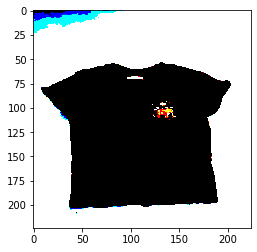

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


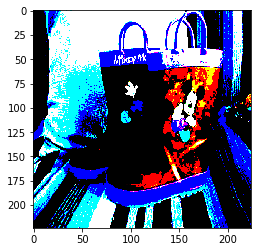

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


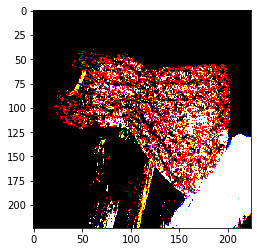

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]





In [4]:
X_train, X_test, Y_train, Y_test = create_dataset()

In [5]:
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(20, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in conv_model.layers:
    layer.trainable = False

In [7]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = full_model.fit(
    X_train,
    Y_train,
    workers=0,
    epochs=10,
    batch_size=32,
)

C:\Users\bdasg\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
161/161 [==============================] - 16s 70ms/step - loss: 1.9882 - acc: 0.5766
Epoch 2/10
161/161 [==============================] - 11s 70ms/step - loss: 0.5460 - acc: 0.8374
Epoch 3/10
161/161 [==============================] - 11s 69ms/step - loss: 0.2093 - acc: 0.9431
Epoch 4/10
161/161 [==============================] - 11s 68ms/step - loss: 0.0837 - acc: 0.9844
Epoch 5/10
161/161 [==============================] - 11s 66ms/step - loss: 0.0395 - acc: 0.9955
Epoch 6/10
161/161 [==============================] - 11s 67ms/step - loss: 0.0210 - acc: 0.9986
Epoch 7/10
161/161 [==============================] - 11s 68ms/step - loss: 0.0116 - acc: 0.9994
Epoch 8/10
161/161 [==============================] - 11s 69ms/step - loss: 0.0082 - acc: 0.9996
Epoch 9/10
161/161 [==============================] - 11s 67ms/step - loss: 0.0055 - acc: 1.0000
Epoch 10/10
161/161 [==============================] - 11s 68ms/step - loss: 0.0040 - acc: 1.0000


In [9]:
results = full_model.evaluate(X_test, Y_test, batch_size=32)

9/9 [==============================] - 2s 155ms/step - loss: 1.4840 - acc: 0.7333


In [16]:
full_model.save('new_IC_Model_2/ANICModel')

INFO:tensorflow:Assets written to: new_IC_Model_2/ANICModel\assets
